In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

**Given Initial Conditions**

In [ ]:
mars_R = 3396.19 #km
mars_mu = 42828.3 #km /s

#For LMO
altitude = 400 #km 
r_LMO = mars_R + altitude
theta_dot_LMO = np.sqrt(mars_mu/r_LMO**3) #rad/sec
t_LMO = 330 #s
angles_LMO = np.array([20,30,60])*np.pi/180 #Ω,i,θ(t_0), in radians
angles_LMO += np.array([0,0, theta_dot_LMO*t_LMO]) #Ω,i,θ(t), in radians

#For GMO
r_GMO = 20424.2 #km
theta_dot_GMO = np.sqrt(mars_mu/r_GMO**3) #rad/s
t_GMO = 1150 #s
angles_GMO = np.array([0,0,250])*np.pi/180 #Ω,i,θ(t_0), in radians
angles_GMO += np.array([0,0, theta_dot_GMO*t_GMO]) #Ω,i,θ(t), in radians

#For Spacecraft
sigma_BN = np.array([0.3, -0.4, 0.5])
w_BN_B = np.array([1.0, 1.75, -2.2])*np.pi/180
I = np.array([[10,0,0],[0,5,0],[0,0,7.5]])

In [ ]:
def DCM_from_euler(x, seq):
   # This function computes the Direct Cosine Matrix (DCM) from a set of Euler angles and its rotational sequence
    
    for e in x:
        while e>2*np.pi:
            e -= 2*np.pi
    DCM_all = []
    
    for i,s in enumerate(seq):
        if s==3:
            # 3
            DCM_all.append(np.array([[ math.cos(x[i]), math.sin(x[i]),  0],
                   [ -math.sin(x[i]),  math.cos(x[i]), 0],
                   [ 0,  0,  1]]))
        elif s==2:
            # 2
            DCM_all.append(np.array([[ math.cos(x[i]), 0,  -math.sin(x[i])],
                   [ 0, 1, 0],
                   [ math.sin(x[i]),  0,  math.cos(x[i])]]))
        elif s==1:
            # 1
            DCM_all.append(np.array([[ 1, 0,  0],
                   [ 0,  math.cos(x[i]), math.sin(x[i])],
                   [ 0,  -math.sin(x[i]),  math.cos(x[i])]]))
    if len(seq)!=3:
        print("Kindly Recheck!!. Sequence does not have a length of 3.")
        return None
    final_DCM = DCM_all[2]@DCM_all[1]@DCM_all[0]
    return final_DCM

In [ ]:
def inertial_r_r_dot(r, angle):
    
    # This Takes the norm of the position vector and the set of Euler angles and returns the position and velocity vector in the inertial frame
    
    mars_mu = 42828.3 #km /s    
    theta_dot = np.sqrt(mars_mu/r**3) #in rad/s
    
    NH = DCM_from_euler(angle, [3, 1, 3])
    r_H = np.array([r, 0, 0])
    r_inertial = NH.T@r_H
    
    r_dot = np.array([0, r*theta_dot, 0]) #[r, theta, h], in km/s
    r_dot_inertial = NH.T@r_dot
    return r_inertial, r_dot_inertial

**Orbit Frame Orientation (Task-2)**

In [ ]:
def DCM_HN(t):
    
   # This Function Computes the Direct Cosine Matrix from the Hill Frame (LMO) to the inertial frame (N)
    
  
    # Initial conditions for LMO
    mars_R = 3396.19 #km
    mars_mu = 42828.3 #km /s
    altitude = 400 #km 
    r_LMO = mars_R + altitude
    theta_dot_LMO = np.sqrt(mars_mu/r_LMO**3) #rad/sec
    angles_LMO = np.array([20,30,60])*np.pi/180 #Ω,i,θ(t_0), in radians
    angles_LMO += np.array([0,0, theta_dot_LMO*t]) #Ω,i,θ(t), in radians
    
    #Computing inertial vectors
    r_inertial_LMO, r_dot_inertial_LMO = inertial_r_r_dot(r_LMO, angles_LMO)
    
    #Computing Hill Frame versors
    i_r = r_inertial_LMO/np.linalg.norm(r_inertial_LMO)
    i_h = np.cross(r_inertial_LMO, r_dot_inertial_LMO)/np.linalg.norm(\
                            np.cross(r_inertial_LMO, r_dot_inertial_LMO))
    i_theta = np.cross(i_h, i_r)
    HN = np.array([i_r, i_theta, i_h])
    return HN

**Sun-Pointing Reference Frame Orientation (Task-3)**

In [ ]:
def RsN():
    
    # This function Returns the Direct Cosine Matrix (DCM) from the Rs (Sun) frame to the N (Mars) frame
    
    r_1 = np.array([-1.,0.,0.])
    r_2 = np.array([0.,0.,1.])
    r_3 = np.array([0.,1.,0.])
    RsN = np.array([r_1, r_2, r_3])
    return RsN

**Nadir-Pointing Reference Frame Orientation (Task-4)**

In [ ]:
def RnN(t):
    
    #This Function Computes the Direct Cosine Matrix (DCM) from the Nadir Reference Frame (NRF) (Rn) to the inertial frame (IF) (N)
    
    # Defining the versors from Rn in the Hill Frame (LMO) to construct the DCM [HRn]
    r_1 = np.array([-1,0,0])
    r_2 = np.array([0,1,0])
    r_3 = np.array([0,0,-1])
    DCM_HRn = np.array([r_1, r_2, r_3])
    
    # [RnN] = [RnH][HN]
    RnN = DCM_HRn.T@DCM_HN(t)
    return RnN

In [ ]:
def w_RnN(t):
   
    # Initial conditions for LMO
    mars_R = 3396.19 #km
    mars_mu = 42828.3 #km /s
    altitude = 400 #km 
    r_LMO = mars_R + altitude
    theta_dot_LMO = np.sqrt(mars_mu/r_LMO**3) #rad/sec   
    
    # w normally would be, in the H frame:
    w_HN_H = np.array([0,0,theta_dot_LMO])
    
    # Now we just compute that in the N frame
    w_HN_N =  DCM_HN(t).T@w_HN_H
    
    # But we know that w_RnH should be 0, since we H and Rn are practically coaligned
    w_RnN_N = w_HN_N
    return w_RnN_N

**GMO-Pointing Reference Frame Orientation (Task-5)**

In [ ]:
def RcN(t):
   
    mars_R = 3396.19
    mars_mu = 42828.3

    #LMO
    altitude = 400
    r_LMO = mars_R + altitude
    theta_dot_LMO = np.sqrt(mars_mu/r_LMO**3)
    angles_LMO = np.array([20,30,60])*np.pi/180 
    angles_LMO += np.array([0,0, theta_dot_LMO*t]) 

    #GMO
    r_GMO = 20424.2
    theta_dot_GMO = np.sqrt(mars_mu/r_GMO**3)
    angles_GMO = np.array([0,0,250])*np.pi/180 
    angles_GMO += np.array([0,0, theta_dot_GMO*t]) 
    
    # Building delta_r
    r_GMO_inertial, v_GMO_inertial = inertial_r_r_dot(r_GMO, angles_GMO)
    r_LMO_inertial, v_LMO_inertial = inertial_r_r_dot(r_LMO, angles_LMO)
    delta_r = r_GMO_inertial - r_LMO_inertial
    
    #Rc frame
    n_3 = np.array([0,0,1])
    rc_1 = -delta_r/np.linalg.norm(delta_r)
    rc_2 = np.cross(delta_r, n_3)/np.linalg.norm(np.cross(delta_r, n_3))
    rc_3 = np.cross(rc_1, rc_2)
    
    DCM_RcN = np.array([rc_1, rc_2, rc_3])
    return DCM_RcN

In [ ]:
def w_RcN(t):
  
    dt = 0.1
    RcN_dot = (RcN(t+dt) - RcN(t))/dt
    w_tilde = -RcN(t).T@RcN_dot
    w = np.array([-w_tilde[1][2],w_tilde[0][2],-w_tilde[0][1]])
    return w

**Attitude Error Evaluation (Task-6)**

In [ ]:
def dcm_to_euler_params(BN):
   
    tr = BN[1][1]+BN[2][2]+BN[0][0]
    beta0quad = 1/4*(1+tr)
    beta1quad = 1/4*(1+2*BN[0][0]-tr)
    beta2quad = 1/4*(1+2*BN[1][1]-tr)
    beta3quad = 1/4*(1+2*BN[2][2]-tr)
    betaquad = np.array([beta0quad, beta1quad, beta2quad, beta3quad])
    beta = np.zeros(4)
    beta[betaquad.argmax()] = np.sqrt(betaquad.max())
    if betaquad.argmax() == 0:
        beta[1] = 1/4*(BN[1][2]-BN[2][1])/beta[0]
        beta[2] = 1/4*(BN[2][0]-BN[0][2])/beta[0]
        beta[3] = 1/4*(BN[0][1]-BN[1][0])/beta[0]
    elif betaquad.argmax() == 1:
        beta[0] = 1/4*(BN[1][2]-BN[2][1])/beta[1]
        beta[2] = 1/4*(BN[0][1]+BN[1][0])/beta[1]
        beta[3] = 1/4*(BN[2][0]+BN[0][2])/beta[1]
    elif betaquad.argmax() == 2:
        beta[0] = 1/4*(BN[2][0]-BN[0][2])/beta[2]
        beta[1] = 1/4*(BN[0][1]+BN[1][0])/beta[2]
        beta[3] = 1/4*(BN[1][2]+BN[2][1])/beta[2]
    elif betaquad.argmax() == 3:
        beta[0] = 1/4*(BN[0][1]-BN[1][0])/beta[3]   
        beta[1] = 1/4*(BN[2][0]+BN[0][2])/beta[3]
        beta[2] = 1/4*(BN[1][2]+BN[2][1])/beta[3]
    if beta[0]<0:
        beta = -beta
    return beta

In [ ]:
def euler_params_to_sigma(beta):
  
    sigma = np.zeros(3)
    for i in range(3):
        if abs((1+beta[0]))<1e-4:
            print(f'(1 + beta[0]) = {(1+beta[0])} in den. of cell number 54')
            sigma[i] = 0
        else:
            sigma[i] = beta[i+1]/(1+beta[0])
    return np.array(sigma)

In [ ]:
def tilde(sigma):
   
    sigma = np.squeeze(sigma)
    return np.array([[0, -sigma[2],sigma[1]],
                     [sigma[2], 0, -sigma[0]],
                     [-sigma[1], sigma[0], 0]
                     ])

In [ ]:
def sigma_to_dcm(sigma):
   
    sigma_squared = np.inner(sigma, sigma)
    DCM = np.eye(3) + (8*tilde(sigma)@tilde(sigma) - 4*(1 - sigma_squared)*tilde(sigma) )/ (1 + sigma_squared)**2
    return DCM

In [ ]:
def dcm_to_sigma(matrix):
   
    zeta = np.sqrt(np.trace(matrix) + 1)
    constant = 1 / (zeta**2 + 2 * zeta)
    s1 = constant * (matrix[1, 2] - matrix[2, 1])
    s2 = constant * (matrix[2, 0] - matrix[0, 2])
    s3 = constant * (matrix[0, 1] - matrix[1, 0])
    return np.array([s1, s2, s3])

In [ ]:
def track(t, sigma_BN, w_BN_B, RN, w_RN_N, mode='others'):
   
    global sigma_BR
    
   
    BN = sigma_to_dcm(sigma_BN)
    w_RN_B = BN@w_RN_N
    w_BR_B = w_BN_B - w_RN_B
    
    
    if mode=='quaternions':
        BN = sigma_to_dcm(sigma_BN)
        beta_BN = dcm_to_euler_params(BN)
        beta_NR = dcm_to_euler_params(RN.T)
       
        BN_associated = np.array([[beta_BN[0], -beta_BN[1], -beta_BN[2], -beta_BN[3]],
                         [beta_BN[1], beta_BN[0], beta_BN[3], -beta_BN[2]],
                         [beta_BN[2], -beta_BN[3], beta_BN[0], beta_BN[1]],
                         [beta_BN[3], beta_BN[2], -beta_BN[1], beta_BN[0]]
                         ])
        beta_BR = BN_associated@beta_NR
        if (1 + beta_BR[0]) > 1e-4:
            sigma_BR = euler_params_to_sigma(beta_BR)

    else:
        BR = BN@RN.T
        beta_BR = dcm_to_euler_params(BR)
        sigma_BR = euler_params_to_sigma(beta_BR)
       
    if np.linalg.norm(sigma_BR) > 1:
        norm = np.linalg.norm(sigma_BR)**2
        sigma_BR = np.array([-i / norm for i in sigma_BR])
    
    return sigma_BR, w_BR_B

**Numerical Attitude Simulator (Task-7)**

In [ ]:
def control(t, sigma_BN, w_BN_B, task=7):
    global u_B
    K = 0.005555555555555555
    P = 0.16666666666666666
    if t%1==0:
        if task==7:
            K = np.zeros((3,3))
            P = np.zeros((3,3))
            u_B = -K@sigma_BN - P@w_BN_B
        elif task==7.5:
            u_B = np.array([0.01,-0.01,0.02])
        elif task==8:
            sigma_BRs, w_BRs_B = track(t, sigma_BN, w_BN_B, RsN(), np.array([0,0,0]))
            u_B = -K*sigma_BRs - P*w_BRs_B
        elif task==9:
            sigma_BRn, w_BRn_B = track(t, sigma_BN, w_BN_B, RnN(t), w_RnN(t))
            u_B = -K*sigma_BRn - P*w_BRn_B
        elif task==10:
            sigma_BRc, w_BRc_B = track(t, sigma_BN, w_BN_B, RcN(t), w_RcN(t))
            u_B = -K*sigma_BRc - P*w_BRc_B
    return u_B

In [ ]:
def wdot(sigma, w, u, L=0):
    
    I = np.array([[10,0,0],[0,5,0],[0,0,7.5]])
    w_dot = np.dot(np.linalg.inv(I), (-np.cross(w, np.dot(I, w)) + u + L))
    return w_dot

In [ ]:
def sigma_dot(sigma, w):
  
    B = 0.25 * np.dot(((1 - np.dot(sigma, sigma)) * np.eye(3) + 2 * tilde(sigma) + 2 * np.outer(sigma,  sigma)), w)
    return B

In [ ]:
def X_dot(t, X, task=7):
    
    # Testing for the shadow set
    if np.linalg.norm(X[:3]) > 1:
        norm = np.linalg.norm(X[:3])**2
        X[:3] = np.array([-i / norm for i in X[:3]])
       
    u = control(t, X[:3], X[3:], task)
    w_BN_B_dot = wdot(X[:3], X[3:], u)
    sigma_BN_dot = sigma_dot(X[:3], X[3:])
    return np.concatenate((sigma_BN_dot, w_BN_B_dot), axis=None)

In [ ]:
def RK4(f, x0, t0, tf, dt):
    
    t = np.arange(t0, tf, dt)
    nt = t.size
    
  
    nx = x0.size
    x = np.zeros((nx, nt))
    
    # Initial conditions
    x[:,0] = x0
    
    for k in range(nt-1):
        
        k1 = dt*f(t[k], x[:, k])
        k2 = dt*f(t[k] + dt/2, x[:, k] + k1/2)
        k3 = dt*f(t[k] + dt/2, x[:, k] + k2/2)
        k4 = dt*f(t[k] + dt, x[:, k] + k3)
        
        
        dx = (k1 + 2*k2 + 2* k3 + k4)/6
        
        
        x[:, k+1] = x[:, k] + dx
        
        
    return x, t

In [ ]:
f = lambda t, X: X_dot(t, X)

x0 = np.concatenate((sigma_BN, w_BN_B))
t0 = 0
tf = 500
dt = 1

x, t = RK4(f, x0, t0, tf, dt)

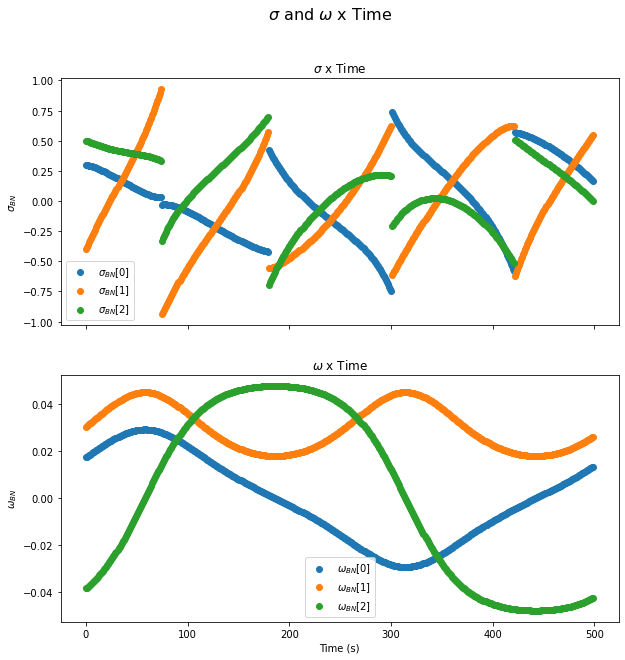

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t, x[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t, x[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t, x[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t, x[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t, x[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t, x[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
w = np.zeros(3)
for wi in range(len(x[3:])):
    w[wi] = x[3:][wi][-1]
H = I@w
print('H_B:', H)

T = 1/2*w.T@I@w
T
print('T:', T)

sigma = np.zeros(3)
for wi in range(len(x[:3])):
    sigma[wi] = x[:3][wi][-1]
    
print('sigma_BN(500s):', sigma)

BN = sigma_to_dcm(sigma)
H_N = BN@H
print('H_N:', H_N)

H_B: [ 0.13510634  0.13121838 -0.31818881]
T: 0.009384120387989947
sigma_BN(500s): [ 0.16576826  0.55008858 -0.0007551 ]
H_N: [0.26949359 0.0914818  0.23605166]


In [ ]:
f_new = lambda t, X_new: X_dot(t, X_new, task=7.5)

x0_new = np.concatenate((sigma_BN, w_BN_B))
t0_new = 0
tf_new = 100
dt = 0.1

x_new, t_new = RK4(f_new, x0_new, t0_new, tf_new, dt)
sigma_new = np.zeros(3)
for wi in range(len(x_new[:3])):
    sigma_new[wi] = x_new[:3][wi][-1]
    
print('sigma_BN(100s):', sigma_new)

sigma_BN(100s): [-0.23541146 -0.64069502  0.23968579]


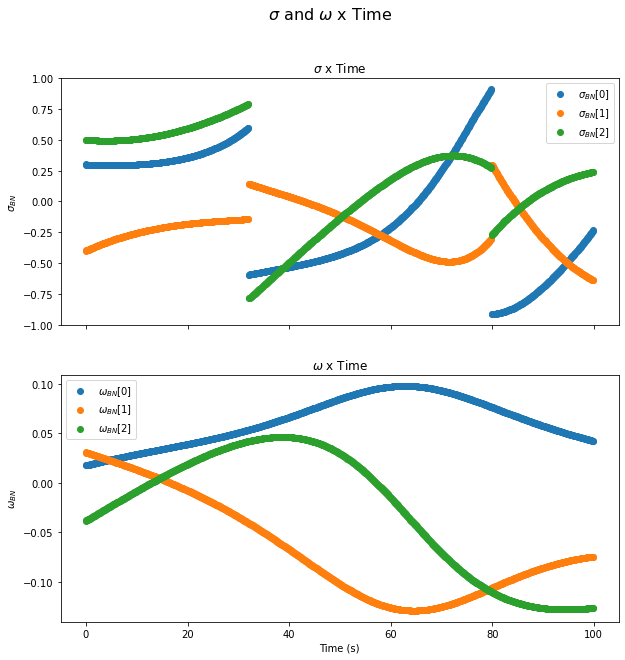

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_new, x_new[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_new, x_new[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_new, x_new[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t_new, x_new[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_new, x_new[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_new, x_new[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

**Sun Pointing Control (Task-8)**

In [ ]:
def evaluate_gains():
    
    P_sample = np.array([10/60, 5/60, 7.5/60]) 
    I_principal = np.array([10,5,7.5])
    K_sample = []

    for j in range(3):
        
        K_sample.append([P_sample[j]**2/I_principal[i] for i in range(3)]) 
    K_sample = np.array(K_sample).reshape(9,)


    for i in range(len(P_sample)):
        for j in range(len(K_sample)):
            xi = []
            T = []
            for k in range(len(I_principal)):
                xi.append(P_sample[i]/np.sqrt(K_sample[j]*I_principal[k]))
                T.append(2*I_principal[k]/P_sample[i])
                print('INITIAL CONDITIONS: I =', I_principal[k], 'K =', K_sample[j], 'P =', P_sample[i])
            print('T:', T)
            print('xi:', xi)
            print('='*10)
        print('='*40)

In [ ]:
f_Rs = lambda t, X_Rs: X_dot(t, X_Rs, task=8)

x0_Rs = np.concatenate((sigma_BN, w_BN_B))
t0_Rs = 0
tf_Rs = 400
dt = 0.1
x_Rs, t_Rs = RK4(f_Rs, x0_Rs, t0_Rs, tf_Rs+dt, dt)

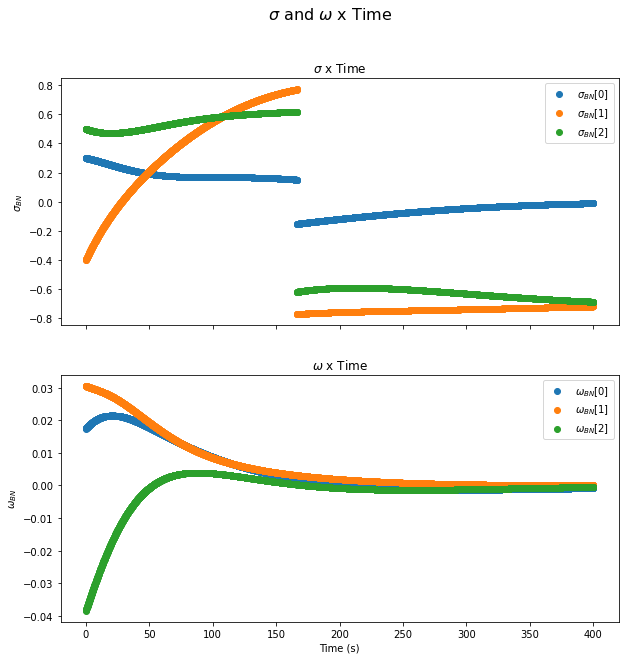

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_Rs, x_Rs[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_Rs, x_Rs[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_Rs, x_Rs[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t_Rs, x_Rs[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_Rs, x_Rs[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_Rs, x_Rs[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
t = 15
sigma_Rs_t = np.zeros(3)
for wi in range(len(x_Rs[:3])):
    sigma_Rs_t[wi] = x_Rs[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rs_t)

with open('task8.2.txt', 'w') as first:
    list_sigma_Rs_t = list(sigma_Rs_t)
    first.write(str(list_sigma_Rs_t[0])+' '+str(list_sigma_Rs_t[1])+' '+str(list_sigma_Rs_t[2]))
    
t = 100
sigma_Rs_t = np.zeros(3)
for wi in range(len(x_Rs[:3])):
    sigma_Rs_t[wi] = x_Rs[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rs_t)

with open('task8.3.txt', 'w') as first:
    list_sigma_Rs_t = list(sigma_Rs_t)
    first.write(str(list_sigma_Rs_t[0])+' '+str(list_sigma_Rs_t[1])+' '+str(list_sigma_Rs_t[2]))
    
t = 200
sigma_Rs_t = np.zeros(3)
for wi in range(len(x_Rs[:3])):
    sigma_Rs_t[wi] = x_Rs[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rs_t)

with open('task8.4.txt', 'w') as first:
    list_sigma_Rs_t = list(sigma_Rs_t)
    first.write(str(list_sigma_Rs_t[0])+' '+str(list_sigma_Rs_t[1])+' '+str(list_sigma_Rs_t[2]))
    
t = 400
sigma_Rs_t = np.zeros(3)
for wi in range(len(x_Rs[:3])):
    sigma_Rs_t[wi] = x_Rs[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rs_t)

with open('task8.5.txt', 'w') as first:
    list_sigma_Rs_t = list(sigma_Rs_t)
    first.write(str(list_sigma_Rs_t[0])+' '+str(list_sigma_Rs_t[1])+' '+str(list_sigma_Rs_t[2]))

sigma_BN(15s): [ 0.26559461 -0.15982421  0.47331693]
sigma_BN(100s): [0.16879131 0.54822701 0.57878748]
sigma_BN(200s): [-0.1182327  -0.75781563 -0.59154336]
sigma_BN(400s): [-0.01012719 -0.71883694 -0.68606249]


**Nadir Pointing Control (Task-9)**

In [ ]:
f_Rn = lambda t, X_Rn: X_dot(t, X_Rn, task=9)

x0_Rn = np.concatenate((sigma_BN, w_BN_B))
t0_Rn = 0
tf_Rn = 400
dt = 0.1
x_Rn, t_Rn = RK4(f_Rn, x0_Rn, t0_Rn, tf_Rn+dt, dt)

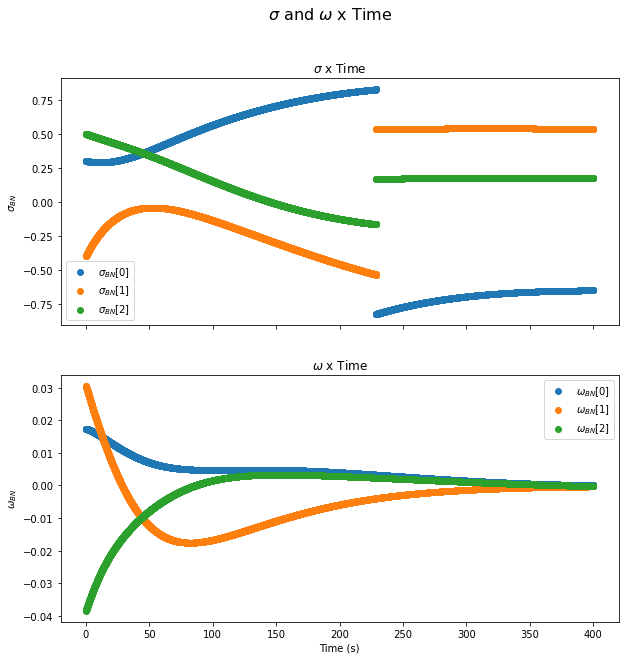

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_Rn, x_Rn[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_Rn, x_Rn[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_Rn, x_Rn[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t_Rn, x_Rn[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_Rn, x_Rn[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_Rn, x_Rn[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
t = 15
sigma_Rn_t = np.zeros(3)
for wi in range(len(x_Rn[:3])):
    sigma_Rn_t[wi] = x_Rn[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rn_t)

with open('task9.1.txt', 'w') as fiRnt:
    list_sigma_Rn_t = list(sigma_Rn_t)
    fiRnt.write(str(list_sigma_Rn_t[0])+' '+str(list_sigma_Rn_t[1])+' '+str(list_sigma_Rn_t[2]))
    
t = 100
sigma_Rn_t = np.zeros(3)
for wi in range(len(x_Rn[:3])):
    sigma_Rn_t[wi] = x_Rn[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rn_t)

with open('task9.2.txt', 'w') as fiRnt:
    list_sigma_Rn_t = list(sigma_Rn_t)
    fiRnt.write(str(list_sigma_Rn_t[0])+' '+str(list_sigma_Rn_t[1])+' '+str(list_sigma_Rn_t[2]))
    
t = 200
sigma_Rn_t = np.zeros(3)
for wi in range(len(x_Rn[:3])):
    sigma_Rn_t[wi] = x_Rn[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rn_t)

with open('task9.3.txt', 'w') as fiRnt:
    list_sigma_Rn_t = list(sigma_Rn_t)
    fiRnt.write(str(list_sigma_Rn_t[0])+' '+str(list_sigma_Rn_t[1])+' '+str(list_sigma_Rn_t[2]))
    
t = 400
sigma_Rn_t = np.zeros(3)
for wi in range(len(x_Rn[:3])):
    sigma_Rn_t[wi] = x_Rn[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rn_t)

with open('task9.4.txt', 'w') as fiRnt:
    list_sigma_Rn_t = list(sigma_Rn_t)
    fiRnt.write(str(list_sigma_Rn_t[0])+' '+str(list_sigma_Rn_t[1])+' '+str(list_sigma_Rn_t[2]))

sigma_BN(15s): [ 0.29107122 -0.19122519  0.45350703]
sigma_BN(100s): [ 0.56609163 -0.13729815  0.15222513]
sigma_BN(200s): [ 0.79578935 -0.45968407 -0.12651628]
sigma_BN(400s): [-0.6528482   0.53487286  0.17461082]


**GMO Pointing Control (Task-10)**

In [ ]:
f_Rc = lambda t, X_Rc: X_dot(t, X_Rc, task=10)

x0_Rc = np.concatenate((sigma_BN, w_BN_B))
t0_Rc = 0
tf_Rc = 400
dt = 0.1

x_Rc, t_Rc = RK4(f_Rc, x0_Rc, t0_Rc, tf_Rc+dt, dt)

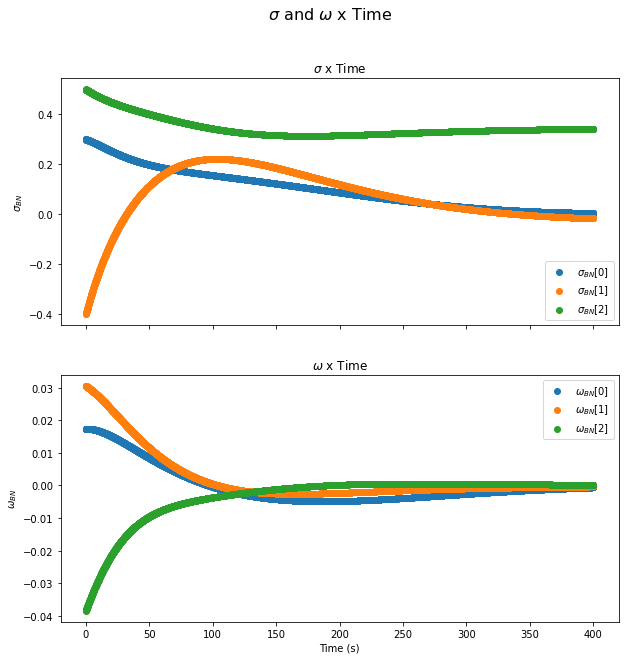

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_Rc, x_Rc[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_Rc, x_Rc[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_Rc, x_Rc[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t_Rc, x_Rc[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_Rc, x_Rc[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_Rc, x_Rc[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
t = 15
sigma_Rc_t = np.zeros(3)
for wi in range(len(x_Rc[:3])):
    sigma_Rc_t[wi] = x_Rc[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rc_t)

with open('task10.1.txt', 'w') as fiRct:
    list_sigma_Rc_t = list(sigma_Rc_t)
    fiRct.write(str(list_sigma_Rc_t[0])+' '+str(list_sigma_Rc_t[1])+' '+str(list_sigma_Rc_t[2]))
    
t = 100
sigma_Rc_t = np.zeros(3)
for wi in range(len(x_Rc[:3])):
    sigma_Rc_t[wi] = x_Rc[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rc_t)

with open('task10.2.txt', 'w') as fiRct:
    list_sigma_Rc_t = list(sigma_Rc_t)
    fiRct.write(str(list_sigma_Rc_t[0])+' '+str(list_sigma_Rc_t[1])+' '+str(list_sigma_Rc_t[2]))
    
t = 200
sigma_Rc_t = np.zeros(3)
for wi in range(len(x_Rc[:3])):
    sigma_Rc_t[wi] = x_Rc[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rc_t)

with open('task10.3.txt', 'w') as fiRct:
    list_sigma_Rc_t = list(sigma_Rc_t)
    fiRct.write(str(list_sigma_Rc_t[0])+' '+str(list_sigma_Rc_t[1])+' '+str(list_sigma_Rc_t[2]))
    
t = 400
sigma_Rc_t = np.zeros(3)
for wi in range(len(x_Rc[:3])):
    sigma_Rc_t[wi] = x_Rc[:3][wi][int(t/dt)]
    
print('sigma_BN(' + str(t) + 's):', sigma_Rc_t)

with open('task10.4.txt', 'w') as fiRct:
    list_sigma_Rc_t = list(sigma_Rc_t)
    fiRct.write(str(list_sigma_Rc_t[0])+' '+str(list_sigma_Rc_t[1])+' '+str(list_sigma_Rc_t[2]))

sigma_BN(15s): [ 0.26543804 -0.16878399  0.45948446]
sigma_BN(100s): [0.15613891 0.22167733 0.34312546]
sigma_BN(200s): [0.087283   0.1194033  0.31615782]
sigma_BN(400s): [ 0.00497672 -0.01647214  0.34238458]


**Final Task-Mission Scenario Simulation (Task-11)**

In [ ]:
def pos(t):
  
    altitude = 400 #km 
    r_LMO = mars_R + altitude
    theta_dot_LMO = np.sqrt(mars_mu/r_LMO**3) 
    angles_LMO = np.array([20,30,60])*np.pi/180 
    angles_LMO += np.array([0,0, theta_dot_LMO*t]) 
    r_inertial,_ = inertial_r_r_dot(r_LMO, angles_LMO)
    return r_inertial

In [ ]:
def define_frame(t):
  
    r = pos(t)
    
    if r[1] > 0:
       
        frame = 'Rs'
    
   
    else:
       
        r_GMO = 20424.2 #km
        theta_dot_GMO = np.sqrt(mars_mu/r_GMO**3) 
        angles_GMO = np.array([0,0,250])*np.pi/180 
        angles_GMO += np.array([0,0, theta_dot_GMO*t]) 
       
        r_GMO_inertial, _ = inertial_r_r_dot(r_GMO, angles_GMO)
        delta_r = r_GMO_inertial - r
        
       
        angle = np.arccos(np.dot(r, r_GMO_inertial)/np.linalg.norm(r)/np.linalg.norm(r_GMO_inertial))

        angle *= 180/np.pi
        
        if angle < 35 and angle > -35:
            
            frame = 'Rc'
        
        else:
            
            frame = 'Rn'
    
    return frame

In [ ]:
for t in np.arange(5468, 5469, 0.1):
    print(define_frame(t), t)

Rn 5468.0
Rs 5468.1
Rs 5468.200000000001
Rs 5468.300000000001
Rs 5468.4000000000015
Rs 5468.500000000002
Rs 5468.600000000002
Rs 5468.700000000003
Rs 5468.800000000003
Rs 5468.900000000003


In [ ]:
def change_of_frames():
   
    tot = 6500
    altitude = 1

    frames = []
    change_of_frames = {}


    for t in range(0, tot, altitude):
        frames.append(define_frame(t))
        if frames[t]!=frames[t-1]:
            change_of_frames[frames[t-1]+'->'+frames[t]] = t
    return change_of_frames

In [ ]:
dic_changes = change_of_frames()
list_changes = list(dic_changes.values())

list_changes

[1918, 3057, 4067, 5469]

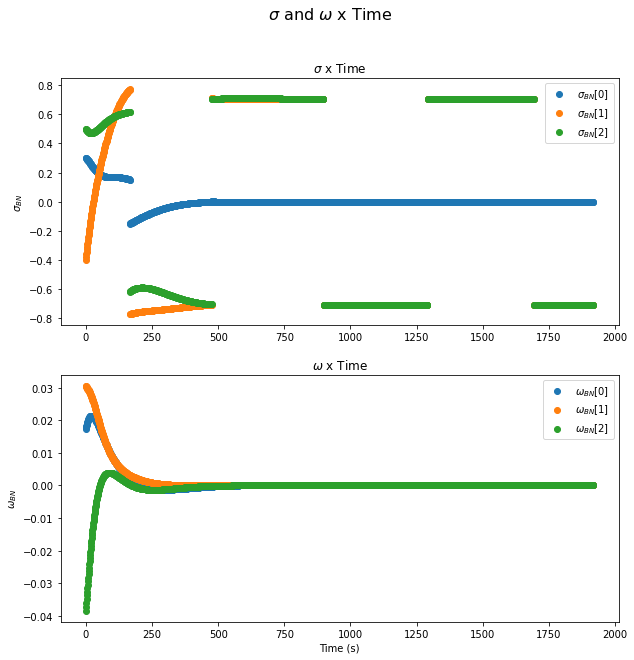

In [ ]:
f_Rs = lambda t, X_Rs: X_dot(t, X_Rs, task=8)

x0_Rs = np.concatenate((sigma_BN, w_BN_B))
t0_Rs = 0
tf_Rs = list_changes[0]

dt = 1

x_Rs, t_Rs = RK4(f_Rs, x0_Rs, t0_Rs, tf_Rs, dt)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_Rs, x_Rs[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_Rs, x_Rs[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_Rs, x_Rs[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')


ax2.scatter(t_Rs, x_Rs[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_Rs, x_Rs[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_Rs, x_Rs[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
print(f'sigma(300s) = {x_Rs[0][int(300//dt)]} {x_Rs[1][int(300//dt)]} {x_Rs[2][int(300//dt)]}')

sigma(300s) = -0.04430505681471622 -0.7387613206031678 -0.6304173568057777


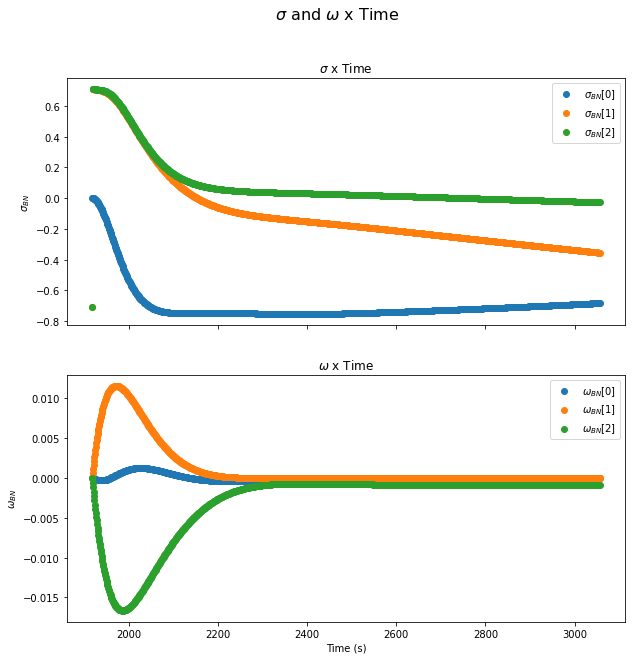

In [ ]:
f_Rn = lambda t, X_Rn: X_dot(t, X_Rn, task=9)

x0_Rn = np.concatenate((sigma_BN, w_BN_B))
for i in range(6):
    x0_Rn[i] = x_Rs[i][-1]
t0_Rn = list_changes[0]
tf_Rn = list_changes[1]
dt = 1

x_Rn, t_Rn = RK4(f_Rn, x0_Rn, t0_Rn, tf_Rn, dt)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_Rn, x_Rn[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_Rn, x_Rn[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_Rn, x_Rn[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t_Rn, x_Rn[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_Rn, x_Rn[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_Rn, x_Rn[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
print(f'sigma(2100s) = {x_Rn[0][int((2100-list_changes[0])/dt)]} {x_Rn[1][int((2100-list_changes[0])/dt)]} {x_Rn[2][int((2100-list_changes[0])/dt)]}')

sigma(2100s) = -0.7457011487076526 0.11463108205344132 0.1587569719735829


In [ ]:
list_changes

[1918, 3057, 4067, 5469]

-0.6820335172206491
-0.3544755111555266
-0.026741101471685215
-6.149981498514968e-07
-1.0000094349218488e-07
-0.0008848611050954353


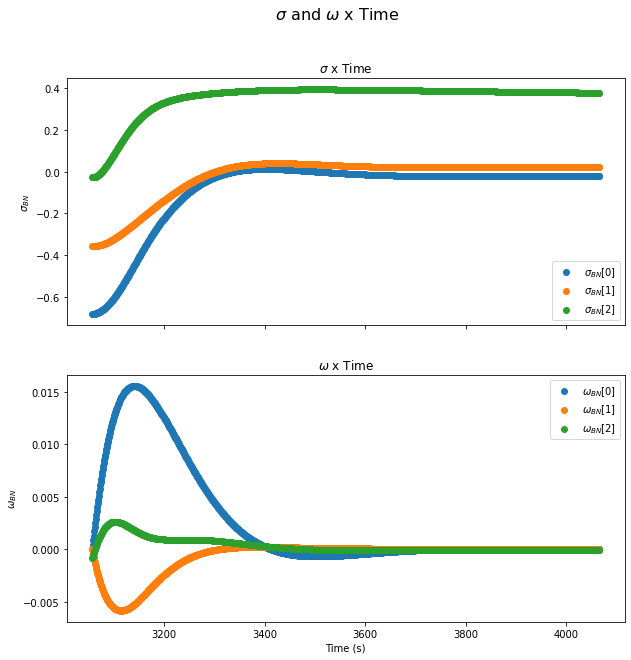

In [ ]:
f_Rc = lambda t, X_Rc: X_dot(t, X_Rc, task=10)

x0_Rc = np.concatenate((sigma_BN, w_BN_B))
for i in range(6):
    x0_Rc[i] = x_Rn[i][-1]
    print(x_Rn[i][-1])
t0_Rc = list_changes[1]
tf_Rc = list_changes[2]
dt = 1

x_Rc, t_Rc = RK4(f_Rc, x0_Rc, t0_Rc, tf_Rc, dt)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_Rc, x_Rc[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_Rc, x_Rc[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_Rc, x_Rc[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t_Rc, x_Rc[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_Rc, x_Rc[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_Rc, x_Rc[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
t_chg2 = 3400 
print(f'sigma(3400s) = {x_Rc[0][int((t_chg2-list_changes[1])/dt)]} {x_Rc[1][int((t_chg2-list_changes[1])/dt)]} {x_Rc[2][int((t_chg2-list_changes[1])/dt)]}')
list_changes

sigma(3400s) = 0.013140275713223609 0.03973505765794127 0.39064252672658506


[1918, 3057, 4067, 5469]

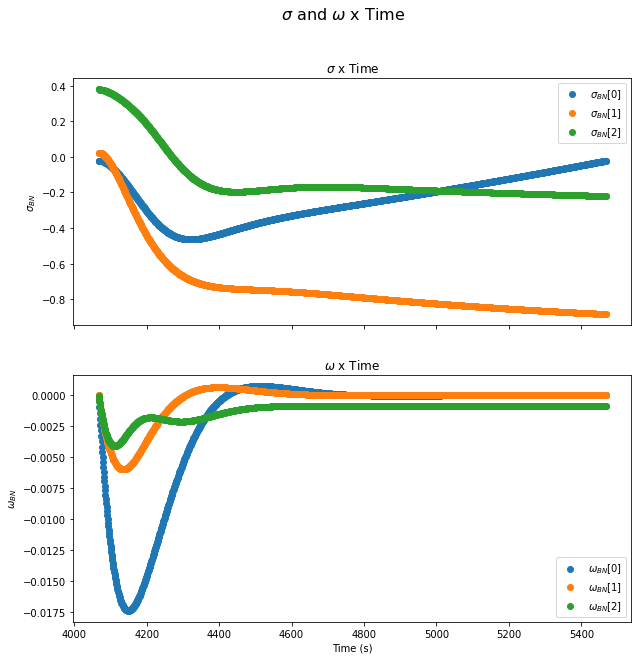

In [ ]:
f_Rn_2 = lambda t, X_Rn_2: X_dot(t, X_Rn_2, task=9)

x0_Rn_2 = np.concatenate((sigma_BN, w_BN_B))
for i in range(6):
    x0_Rn_2[i] = x_Rc[i][-1]
t0_Rn_2 = list_changes[2]
tf_Rn_2 = list_changes[3]
dt = 1

x_Rn_2, t_Rn_2 = RK4(f_Rn_2, x0_Rn_2, t0_Rn_2, tf_Rn_2, dt)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_Rn_2, x_Rn_2[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_Rn_2, x_Rn_2[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_Rn_2, x_Rn_2[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t_Rn_2, x_Rn_2[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_Rn_2, x_Rn_2[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_Rn_2, x_Rn_2[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
t_chg2 = 4400 
print(f'sigma(4400s) = {x_Rn_2[0][int((t_chg2-list_changes[2])/dt)]} {x_Rn_2[1][int((t_chg2-list_changes[2])/dt)]} {x_Rn_2[2][int((t_chg2-list_changes[2])/dt)]}')

sigma(4400s) = -0.4332431075157892 -0.732308772192696 -0.18755911756124535


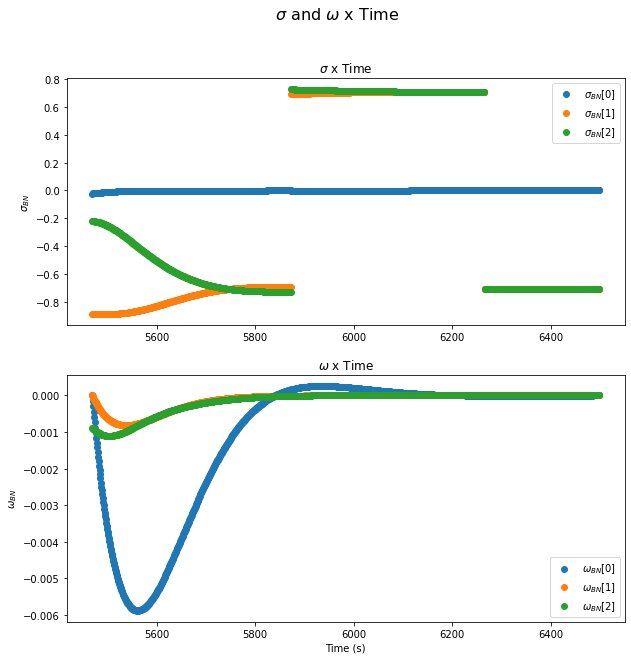

In [ ]:
f_Rs_2 = lambda t, X_Rs_2: X_dot(t, X_Rs_2, task=8)

x0_Rs_2 = np.concatenate((sigma_BN, w_BN_B))
for i in range(6):
    x0_Rs_2[i] = x_Rn_2[i][-1]
t0_Rs_2 = list_changes[-1]
tf_Rs_2 = 6500
dt = 1

x_Rs_2, t_Rs_2 = RK4(f_Rs_2, x0_Rs_2, t0_Rs_2, tf_Rs_2, dt)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

f.suptitle("$\sigma$ and $\omega$ x Time", fontsize=16)

ax1.scatter(t_Rs_2, x_Rs_2[0][:], label='$\sigma_{BN}$[0]')
ax1.scatter(t_Rs_2, x_Rs_2[1][:], label='$\sigma_{BN}$[1]')
ax1.scatter(t_Rs_2, x_Rs_2[2][:], label='$\sigma_{BN}$[2]')
ax1.set_ylabel('$\sigma_{BN}$')
ax1.legend()
ax1.set_title('$\sigma$ x Time')

ax2.scatter(t_Rs_2, x_Rs_2[3][:], label='$\omega_{BN}$[0]')
ax2.scatter(t_Rs_2, x_Rs_2[4][:], label='$\omega_{BN}$[1]')
ax2.scatter(t_Rs_2, x_Rs_2[5][:], label='$\omega_{BN}$[2]')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('$\omega_{BN}$')
ax2.legend()
ax2.set_title('$\omega$ x Time')

plt.show()

In [ ]:
t_chg2 = 5600
print(f'sigma(5600s) = {x_Rs_2[0][int((t_chg2-list_changes[-1])/dt)]} {x_Rs_2[1][int((t_chg2-list_changes[-1])/dt)]} {x_Rs_2[2][int((t_chg2-list_changes[-1])/dt)]}')

sigma(5600s) = -0.001286413908824736 -0.8261093421593287 -0.503949218496923
